In [13]:
import numpy as np
np.random.seed(42)
from tqdm import tqdm_notebook as tqdm


import torch
import sys
import pickle
import wandb
import os
from argparse import ArgumentParser
import wandb
import torch.nn.functional as F


import matplotlib
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [14]:
A = torch.diag( torch.tensor( [1., 0.4], dtype=torch.float64 ) )

In [15]:
from scipy.optimize import fsolve
from functools import partial
def pre_image_norm(norm, w, A, eta=1.):
    return torch.abs(torch.norm( torch.inverse(-A +torch.tensor(norm)* torch.eye(2)).matmul(w))-1)

def pre_image( image , A = A, eta=1.):

    norm = fsolve(partial(pre_image_norm, w= image, A =A), A[1][1]-0.001)
    return  torch.inverse(-A +torch.tensor(norm)* torch.eye(2)).matmul(image) * norm


In [16]:
norm = 0.001
a2 = 0.05

tilde_a = torch.tensor([np.sqrt(1-a2**2/(A[1][1]-norm)**2)* (-A[0][0]+norm), a2],dtype=torch.float64) 
new_tilde_a = torch.inverse(-A +norm* torch.eye(2)).matmul(tilde_a)
new_tilde_a = new_tilde_a * norm

wt = torch.tensor( pre_image(pre_image(new_tilde_a)), requires_grad=True, dtype=torch.float64, device="cpu")


<ipython-input-16-fa9095818720>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wt = torch.tensor( pre_image(pre_image(new_tilde_a)), requires_grad=True, dtype=torch.float64, device="cpu")


In [17]:
lr = 1.

cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
norm_Ax = []
num_epochs = 11
top_Ax = []

for epoch in range(num_epochs):

    A_wt = wt.detach()
    ar = A_wt.detach().clone().numpy()
    norm_Ax += [ np.linalg.norm(ar) ]
    top_Ax  += [ np.absolute( ar[0] ) ]

    with torch.no_grad():
        wt = (-A +wt.norm()* torch.eye(2)).matmul(wt/wt.norm())

[1.24858306e-04 3.99875601e-01 1.00066328e-03 9.92491058e-01
 3.05437935e-02 4.30034189e-01 3.16480567e-01 6.81413171e-01
 3.18583541e-01 6.81391860e-01 3.18608128e-01]


<Figure size 640x480 with 0 Axes>

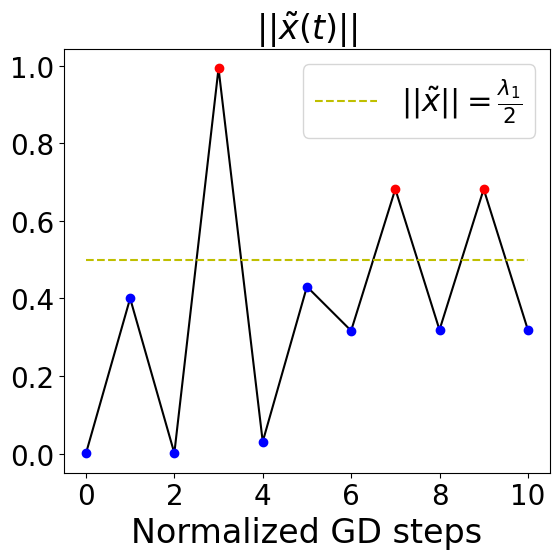

In [18]:
import matplotlib
from matplotlib import pyplot as plt

plt.gcf().clear()
figure, axis = plt.subplots(1, 1, figsize=(6, 6))


norm_Ax = np.asarray( norm_Ax )
print(norm_Ax)
indices_great = np.where( norm_Ax > 0.5 )
indices_less  = np.where( norm_Ax <= 0.5 )

axis.plot(norm_Ax, 'k')
axis.plot(0.5 * np.ones (len(norm_Ax)), 'y--' , label=r'$||'+r'\tilde{x}|| = \frac{\lambda_1}{2}$')
axis.plot(indices_great[0], norm_Ax[indices_great], 'ro')
axis.plot(indices_less[0], norm_Ax[indices_less], 'bo')
axis.set_xlabel('Normalized GD steps')
axis.set_xticks([0,2,4,6,8,10])
axis.legend(loc='upper right')
axis.set_title( '$|| ' + r'\tilde{x}(t) ||$' )
plt.tight_layout()
plt.savefig('norm_Ax.pdf')  
plt.show()

<Figure size 640x480 with 0 Axes>

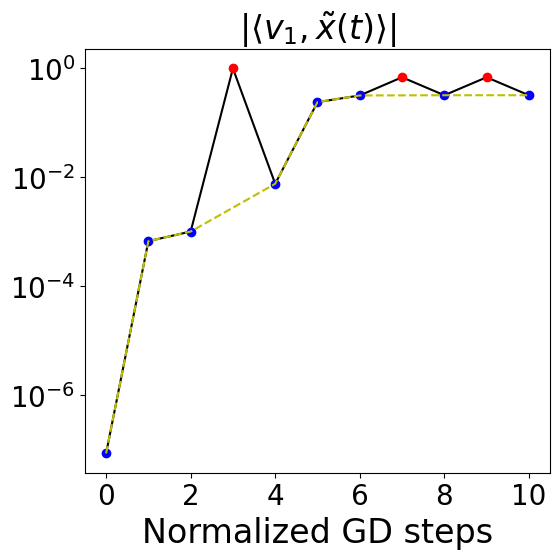

In [19]:
import matplotlib
from matplotlib import pyplot as plt

plt.gcf().clear()

figure, axis = plt.subplots(1, 1, figsize=(6, 6))


top_Ax = np.asarray(top_Ax)
indices_great = np.where( norm_Ax > 0.5 )
indices_less  = np.where( norm_Ax <= 0.5 )

axis.plot(top_Ax, 'k')
axis.plot(indices_great[0], top_Ax[indices_great], 'ro')
axis.plot(indices_less[0], top_Ax[indices_less], 'bo')
axis.plot(indices_less[0], top_Ax[indices_less], 'y--')
axis.set_yscale('log')
axis.set_xlabel('Normalized GD steps')
axis.set_xticks([0,2,4,6,8,10])

axis.set_title( '$| \langle v_1, ' + r'\tilde{x}(t) \rangle|$' )
plt.tight_layout()
plt.savefig('top_Ax.pdf')  
#plt.gcf().clear()
plt.show()

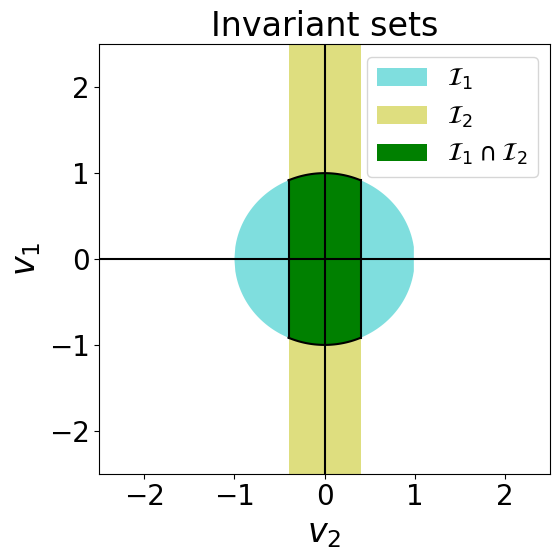

In [20]:
plt.rc('legend', fontsize=18)    # legend fontsize

figure, axis = plt.subplots(1, 1, figsize=(6, 6))


x = np.arange(-0.4, 0.41, 0.01)

y1 = (1. - x**2) ** 0.5
y2 = -(1. - x**2) ** 0.5
axis.axvline(x=0, c="k")
axis.axhline(y=0, c="k")

axis.plot(x, y1, 'k')
axis.plot(x, y2, 'k')
axis.plot(-0.4 * np.ones( 101 ), np.arange(-0.5, 0.51, 0.01) * (y1[0] - y2[0]), 'k' )
axis.plot(0.4 * np.ones( 101 ), np.arange(-0.5, 0.51, 0.01) * (y1[-1] - y2[-1]), 'k' )

x1 = np.arange(-1., 1.0, 0.01)
axis.fill_between(x1, (1. - x1**2) ** 0.5, -(1. - x1**2) ** 0.5, facecolor='c', alpha=0.5, label = "$\mathcal{I}_1$")

x2 = np.arange(-.4, .41, 0.01)
axis.fill_between(x2, np.ones ( len(x2) ) * 2.5, -np.ones ( len(x2) ) * 2.5, facecolor='y', alpha=0.5, label = "$\mathcal{I}_2$")


axis.fill_between(x, y1, y2, facecolor='green', label = "$\mathcal{I}_1 \cap \mathcal{I}_2$")

axis.set_xlabel('$v_2$')
axis.set_ylabel('$v_1$')
axis.set_title('Invariant sets')

axis.legend(ncol=1, loc='upper right')

axis.set_xlim([-2.5, 2.5])
axis.set_ylim([-2.5, 2.5])
plt.tight_layout()
plt.savefig('Invariant_sets.pdf')
plt.show()
